<h1><center>Sveltnet accuracy for the EMNIST dataset</center></h1>

In [22]:
import os, io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import gzip
import requests

import tensorflow as tf

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Flatten, Dense, Conv2DTranspose, GlobalAveragePooling2D, DepthwiseConv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

First thing we need to do is to fetch the EMNIST dataset data.

In [2]:
os.makedirs('res', exist_ok=True)
data = requests.get('https://biometrics.nist.gov/cs_links/EMNIST/gzip.zip')
files = zipfile.ZipFile(io.BytesIO(data.content))
files.extractall('res')

After that, we need to split our data to train and split.

In [23]:
validation_split = 0.3
batch_size = 512
num_of_classes = 62 #MNIST ByClass classes

After that, we will create the required functions in order to speed up the process of loading our data.

In [24]:
def read_MNIST_images(filename):
    with gzip.open(filename, 'rb') as file:
        images = np.frombuffer(file.read(), np.uint8, offset=16)
    return images.reshape(-1, 28, 28, 1).astype("float32") / 255.0
        
def read_MNIST_labels(filename):
    with gzip.open(filename, 'rb') as file:
        labels = np.frombuffer(file.read(), np.uint8, offset=8)
    return labels

x_train = read_MNIST_images('res/gzip/emnist-byclass-train-images-idx3-ubyte.gz')
y_train = read_MNIST_labels('res/gzip/emnist-byclass-train-labels-idx1-ubyte.gz')
x_test = read_MNIST_images('res/gzip/emnist-byclass-test-images-idx3-ubyte.gz')
y_test = read_MNIST_labels('res/gzip/emnist-byclass-test-labels-idx1-ubyte.gz')

We will now prepare the data in order to feed it to our model. We augment the training data and we also create a part of code which selects a sample of our dataset for training our model fast to recognize imperfections.

In [25]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=validation_split, random_state=42)

#------------------------------------------------
#Comment this part of code to test the full dataset 
# dataset_sample_val = 0.1
# x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=(1 - dataset_sample_val), random_state=42)
# x_val, _, y_val, _ = train_test_split(x_val, y_val, test_size=(1 - dataset_sample_val), random_state=42)
# x_test, _, y_test, _ = train_test_split(x_test, y_test, test_size=(1 - dataset_sample_val), random_state=42)
#------------------------------------------------
y_train = to_categorical(y_train, num_of_classes)
y_val = to_categorical(y_val, num_of_classes)
y_test = to_categorical(y_test, num_of_classes)

val_test_generator = ImageDataGenerator()
train_generator = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2)

train_dataset = train_generator.flow(x_train, y_train, batch_size=batch_size)
val_dataset = val_test_generator.flow(x_val, y_val, batch_size=batch_size)
test_dataset = val_test_generator.flow(x_test, y_test, batch_size=batch_size)

We now create the model. As we have to recognize text and we have much more classes, we make our model deeper in order to accomodate for the increased (relative to the digit dataset) number of classes. ------------------------fwaef weaawefawefewafaw

In [16]:
def create_model():
    model = keras.Sequential()
    model.add(Conv2D(16, (5, 5), strides=(1, 1), activation=None, padding='same', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(DepthwiseConv2D((3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(DepthwiseConv2D((3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Conv2D(32, (3, 3), padding='same', activation=None))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(DepthwiseConv2D((3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(DepthwiseConv2D((3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2D(64, (3, 3), padding='same', activation=None))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(DepthwiseConv2D((3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(DepthwiseConv2D((3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2D(64, (3, 3), padding='same', activation=None))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(DepthwiseConv2D((3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(DepthwiseConv2D((3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2D(64, (3, 3), padding='same', activation=None))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(DepthwiseConv2D((3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(DepthwiseConv2D((3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.3))
    model.add(Dense(num_of_classes, activation='softmax')) 

    optimizer = Adam(learning_rate=2e-3)
    loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
    model.compile(optimizer=optimizer,
                  loss=loss_fn,
                  metrics=['accuracy', 'Precision', 'Recall'])
    model.summary()

    return model

model = create_model()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 28, 28, 16)        416       
                                                                 
 batch_normalization_31 (Bat  (None, 28, 28, 16)       64        
 chNormalization)                                                
                                                                 
 re_lu_31 (ReLU)             (None, 28, 28, 16)        0         
                                                                 
 depthwise_conv2d_20 (Depthw  (None, 28, 28, 16)       160       
 iseConv2D)                                                      
                                                                 
 batch_normalization_32 (Bat  (None, 28, 28, 16)       64        
 chNormalization)                                                
                                                      

We then create our callback policy and start training the model.

In [17]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=2.5e-5)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
history = model.fit(train_dataset,
         validation_data=val_dataset,
         epochs=30,
         batch_size=batch_size,
         shuffle=True,
         callbacks=[lr_scheduler, callback])

Epoch 1/30
955/955 [==============================] - 116s 119ms/step - loss: 2.0511 - accuracy: 0.5951 - precision: 0.8318 - recall: 0.3685 - val_loss: 1.3298 - val_accuracy: 0.7913 - val_precision: 0.8702 - val_recall: 0.6824 - lr: 0.0020
Epoch 2/30
955/955 [==============================] - 101s 106ms/step - loss: 1.5335 - accuracy: 0.7541 - precision: 0.8652 - recall: 0.5704 - val_loss: 1.2301 - val_accuracy: 0.8238 - val_precision: 0.8870 - val_recall: 0.7387 - lr: 0.0020
Epoch 3/30
955/955 [==============================] - 97s 102ms/step - loss: 1.4548 - accuracy: 0.7787 - precision: 0.8734 - recall: 0.6152 - val_loss: 1.2740 - val_accuracy: 0.7967 - val_precision: 0.8610 - val_recall: 0.7135 - lr: 0.0020
Epoch 4/30
955/955 [==============================] - 97s 102ms/step - loss: 1.4241 - accuracy: 0.7880 - precision: 0.8759 - recall: 0.6335 - val_loss: 1.1912 - val_accuracy: 0.8326 - val_precision: 0.8876 - val_recall: 0.7663 - lr: 0.0020
Epoch 5/30
955/955 [==================

Lets now plot our data.

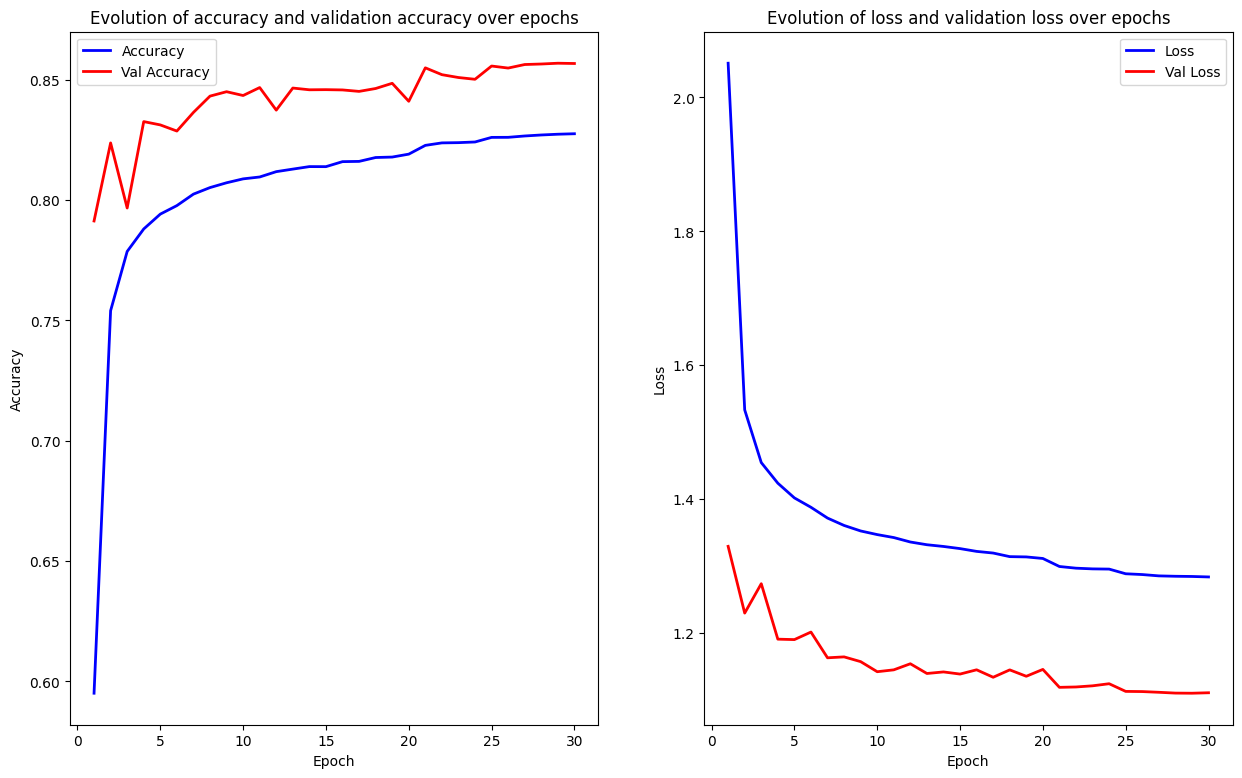

In [18]:
def plot_data_by_epoch(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    loss = history.history['loss']
    v_loss = history.history['val_loss']
    acc = history.history['accuracy']
    v_acc = history.history['val_accuracy']
    
    fig, ax = plt.subplots(1, 2, figsize=(15,9))
    ax[0].plot(epochs, acc, 'b-', linewidth=2, label='Accuracy')
    ax[0].plot(epochs, v_acc, 'r-', linewidth=2, label='Val Accuracy')
    ax[0].set_title('Evolution of accuracy and validation accuracy over epochs')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(loc='best')
    
    ax[1].plot(epochs, loss, 'b-', linewidth=2, label='Loss')
    ax[1].plot(epochs, v_loss, 'r-', linewidth=2, label='Val Loss')
    ax[1].set_title('Evolution of loss and validation loss over epochs')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend(loc='best')
    plt.show()

plot_data_by_epoch(history)

It is clear that some modifications must be made to accomodate for underfitting. Namely, reducing dropout and increasing the layers. Still, our model hits quite high values for its size. After plotting the data, lets test the model's accuracy.

3636/3636 [==============================] - 11s 3ms/step


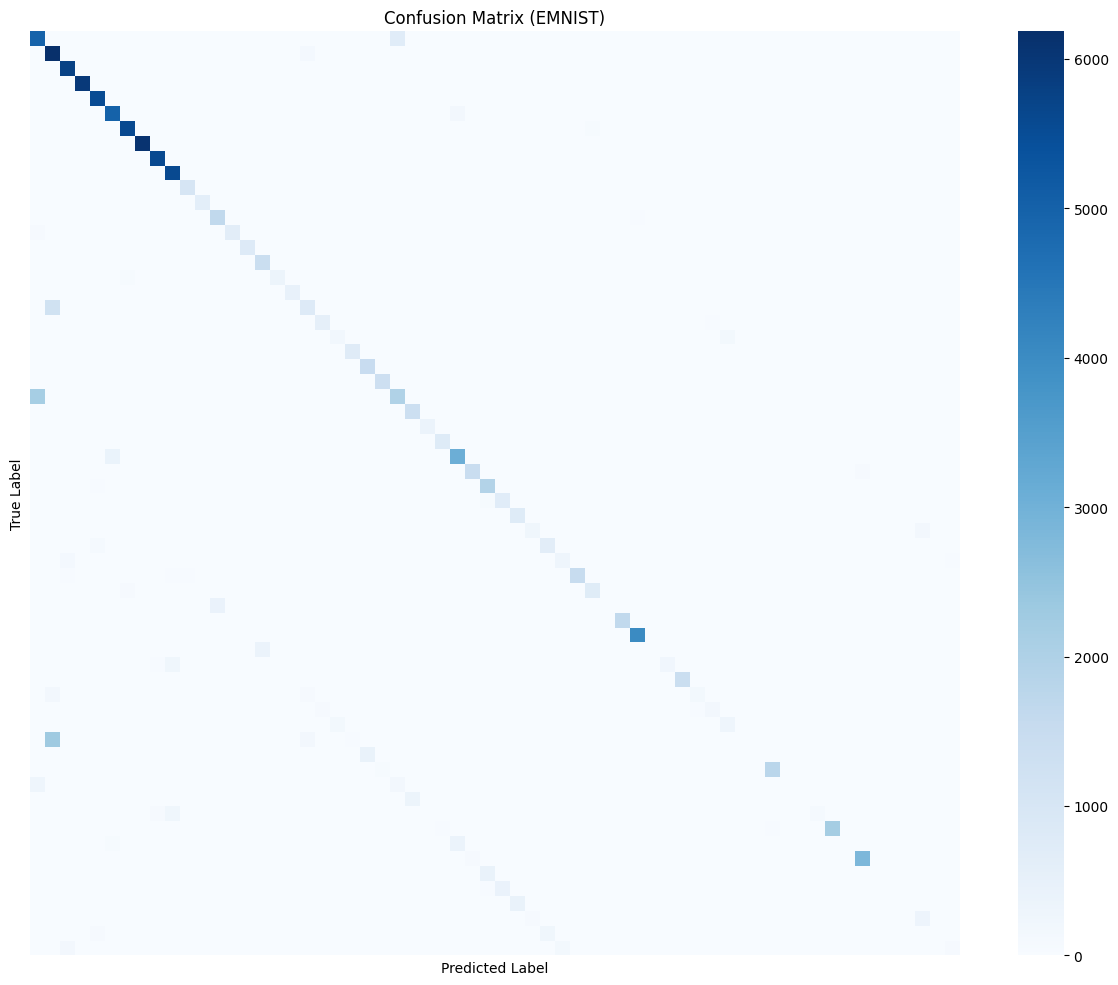

              precision    recall  f1-score   support

           0       0.66      0.86      0.75      5778
           1       0.62      0.98      0.76      6330
           2       0.94      0.98      0.96      5869
           3       0.99      1.00      0.99      5969
           4       0.94      0.99      0.96      5619
           5       0.91      0.96      0.94      5190
           6       0.96      0.98      0.97      5705
           7       0.98      1.00      0.99      6139
           8       0.96      0.99      0.97      5633
           9       0.91      0.99      0.94      5686
          10       0.94      0.99      0.96      1062
          11       0.93      0.96      0.95       648
          12       0.77      0.95      0.85      1739
          13       0.93      0.87      0.90       779
          14       0.96      0.96      0.96       851
          15       0.77      0.98      0.86      1440
          16       0.97      0.81      0.88       447
          17       0.93    

C:\Users\georgelour\miniconda3\envs\testEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\georgelour\miniconda3\envs\testEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\georgelour\miniconda3\envs\testEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [19]:
def test_model(model, test_dataset):
    y_pred = model.predict(x_test)
    y_pred_classes = y_pred.argmax(axis=1)  # Convert probabilities to class labels
    y_true = y_test.argmax(axis=1)  # Convert one-hot labels back to class labels

    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, cmap='Blues', xticklabels=False, yticklabels=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (EMNIST)')
    plt.show()
    
    print(classification_report(y_true, y_pred_classes))

test_model(model, test_dataset)

The accuracy we achieved is quite high. After the normal MNIST and the fashion MNIST, CIFAR10 datasets the model proves to work efficiently with datasets that include much bigger class numbers!

In [20]:
def get_model_metrics(model, test_data, model_title='model'):
    res = model.evaluate(test_data)
    loss, acc, prec, rec = res
    print(model_title)
    print(f'The accuracy of the model is{acc}')
    print(f'The loss of the model is {loss}')
    print(f'The precision of the model is{prec}')
    print(f'The recall of the model is {rec}')
    print('-' * 150 + '\n')

get_model_metrics(model, test_dataset,model_title='Model metrics for MNIST dataset')

228/228 [==============================] - 3s 12ms/step - loss: 1.1095 - accuracy: 0.8568 - precision: 0.8872 - recall: 0.8164
Model metrics for MNIST dataset
The accuracy of the model is0.8568038940429688
The loss of the model is 1.1094542741775513
The precision of the model is0.887213408946991
The recall of the model is 0.8163647651672363
------------------------------------------------------------------------------------------------------------------------------------------------------



In [21]:
model.save("models/model_emnist.keras")

16/16 [==============================] - 0s 13ms/step
The batch's true indices are:
[ 4 31 53  0 49  1 49 40 27 49  9  5 19  1 11 40 53  3  1 28 29  9 55 12
 15 30  6 58 36 61  2  3  0  5  1 24  4  5 53  1  1 10 28  1  1  9 47  9
 44 44  3 26 21  5  5  1 29  4  3  7 57 37 23  0 14  1  7  8 18 40  2 61
  9  3  8 18  6  6  5  7  9  6  6  8 29 16  6 18  7 11  0 49  7 54 11  2
 23 10 22 24 12  2 37  0 40 61  6 28 43  4  9  2  4 28  4  5 24  6 24 39
  1 31 49 55 43  8  0 55 31 28 30 28  1 53 29 18  4  3  7 57  8  9  0  7
 30 59  2  5  2  9 30  8 13 23  5  9  7  5  4 18  8  2 24  2  6 24 55 55
  9  3  2  4  6 14 27 24 53 28  1 11 47 53 37  5  3  0  6 18  5  1 40  4
 24  5  5  7  1  7 42 58 24  8  7  7  2 47 55 15  1  1 32 18  7  7  2  7
  1  1  2  6  8  0  8  6  6  3 28 57  1 12 28  1  5  0 25 18 29 55  1 24
 23 28 12  1  7  8 13 43  9  9  7 53  2  9  9  1 15 53 31 18  7 38 57  1
  5 14 57  7  4  5 55 36 47 46 13 22  8  2  9  1 12  6  4 13 43  9 20 42
  3 40 21 30  3  3 24 53  9  8 12  3 11 

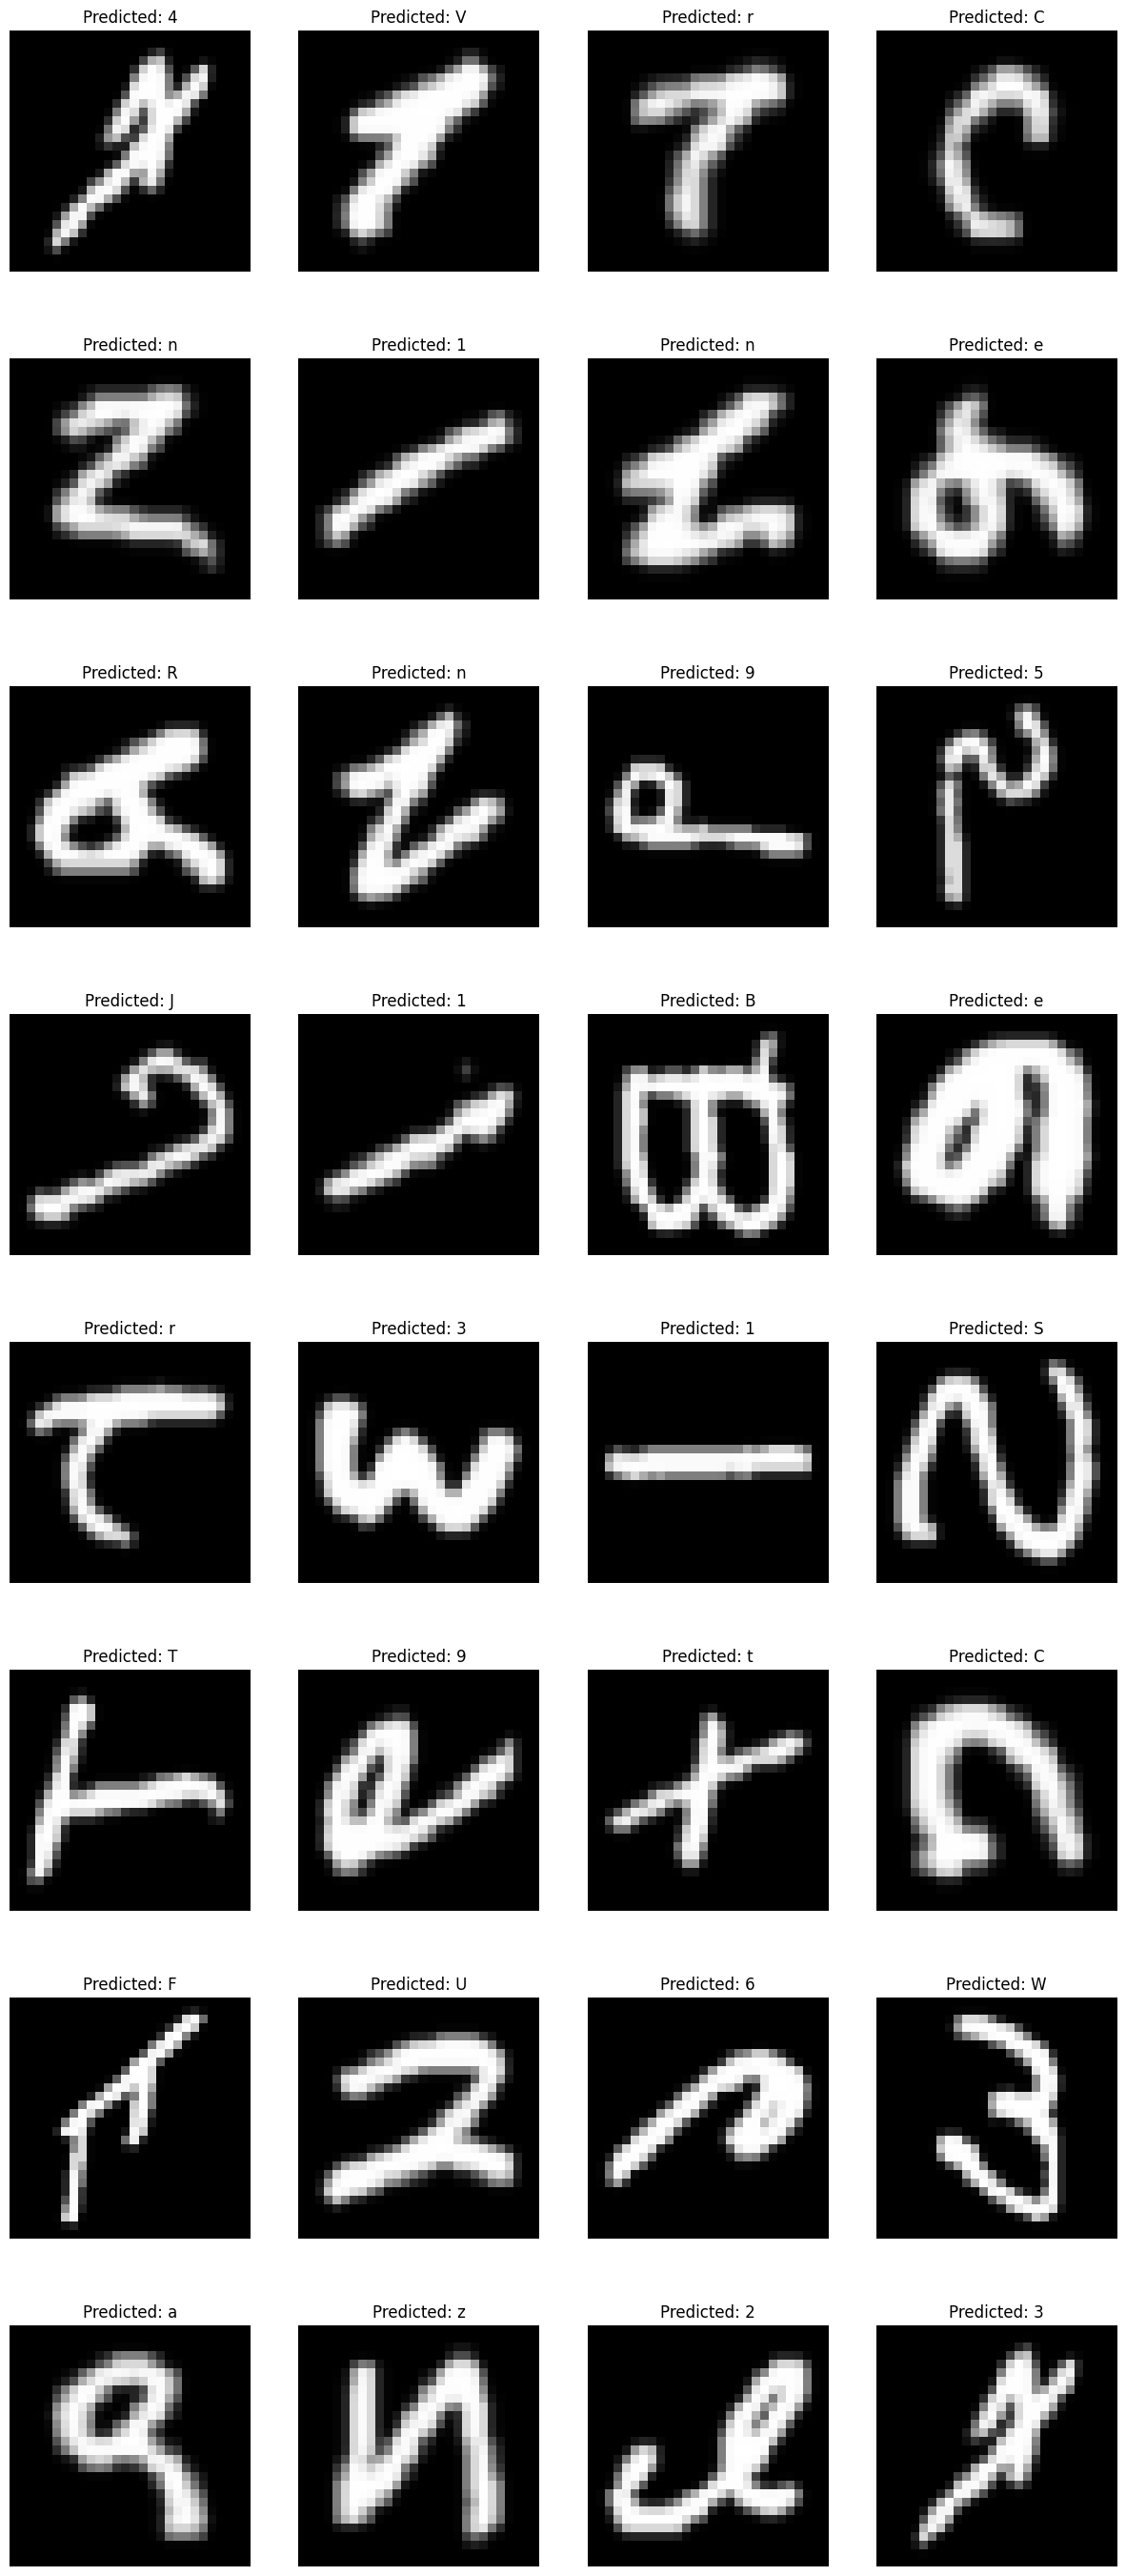

In [27]:
emnist_byclass_labels = {
    0: '0',  1: '1',  2: '2',  3: '3',  4: '4',  5: '5',  6: '6',  7: '7',  8: '8',  9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
    20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
    30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z',
    36: 'a', 37: 'b', 38: 'c', 39: 'd', 40: 'e', 41: 'f', 42: 'g', 43: 'h', 44: 'i', 45: 'j',
    46: 'k', 47: 'l', 48: 'm', 49: 'n', 50: 'o', 51: 'p', 52: 'q', 53: 'r', 54: 's', 55: 't',
    56: 'u', 57: 'v', 58: 'w', 59: 'x', 60: 'y', 61: 'z'
}

def showcase_data(model, dataset, convertor=None):
    fig, ax = plt.subplots(8, 4, figsize=(15, 35))
    batch_images, batch_true_labels = next(dataset)
    batch_predictions = model.predict(batch_images)
    batch_true_indices = np.argmax(batch_true_labels, axis=1)
    batch_pred_indices = np.argmax(batch_predictions, axis=1)
    
    for i in range(32):
        ax[i // 4, i % 4].imshow(batch_images[i].squeeze(), cmap='gray')
        ax[i // 4, i % 4].axis('off')
        if convertor is None:
            ax[i // 4, i % 4].set_title(f'Predicted: {batch_pred_indices[i]}')
        else:
            ax[i // 4, i % 4].set_title(f'Predicted: {convertor[batch_pred_indices[i]]}')
    print("The batch's true indices are:")
    print(batch_true_indices)
    print("The batch's predicted indices are:")
    print(batch_pred_indices)
    plt.imshow(batch_images[0].squeeze(), cmap='gray')

showcase_data(model, test_dataset, convertor=emnist_byclass_labels)